# CSE 572: Lab 18

In this lab, you will practice implementing anomaly detection (also known as outlier detection) techniques for toy datasets. Anomaly detection is the task of identifying instances whose characteristics differ significantly from the rest of the data. You should refer to the lecture slides and Chapter 9 of the "Introduction to Data Mining" book to understand some of the concepts in this tutorial. 

Acknowledgment: This notebook was adapted from Introduction to Data Mining, 2nd Edition. Tan, Steinbach, Karpatne, Kumar.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Load the dataset

We will use two toy datasets to demonstrate some of the techniques we learned in class for novelty detection:
- The MNIST dataset of handwritten digit images (10 classes for digits 0 through 9). Contains 60,000 28x28 grayscale training images and a test set of 10,000 images.
- The FashionMNIST (FMNIST) dataset of fashion/clothing article images (10 classes). Contains 60,000 28x28 grayscale training images and a test set of 10,000 images.

We will use the MNIST dataset as our training set representing normal examples. Our test set will include a mix of normal (MNIST test dataset) and anomalous examples (FashionMNIST test dataset).

In [ ]:
import tensorflow as tf

# Load MNIST
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
print(mnist_x_train.shape)
print(mnist_y_train.shape)
print(mnist_x_test.shape)
print(mnist_y_test.shape)
print()

# Load FashionMNIST
(fmnist_x_train, fmnist_y_train), (fmnist_x_test, fmnist_y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(fmnist_x_train.shape)
print(fmnist_y_train.shape)
print(fmnist_x_test.shape)
print(fmnist_y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


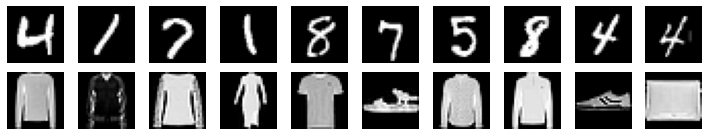

In [ ]:
# Plot some random training examples from each dataset

import matplotlib.pyplot as plt
import numpy as np
# Set the random seed
np.random.seed(0)

n = 10

fig, axes = plt.subplots(ncols=n, nrows=2, figsize=(10,2))
for i in range(n):
    rand = np.random.randint(0, mnist_x_train.shape[0])
    axes[0,i].imshow(mnist_x_train[rand], cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(fmnist_x_train[rand], cmap='gray')
    axes[1,i].axis('off')
    
fig.tight_layout()

## Reconstruction-based approaches

Reconstruction-based approaches assume there are patterns in the distribution of the normal (or majority) class that can be captured using lower-dimensional representations. We reduce the data to a lower dimensional data representation (e.g., using Principal Components Analysis (PCA) or auto-encoders), then measure the reconstruction error for each instance to get its anomaly score. 

We will use PCA to find a lower-dimensional representation of the MNIST training dataset. First we need to choose how many principal components to use for our model. In the cell(s) below, plot the fraction of explained variance for PCA with `n_{components} = [0,100]`. You should use the MNIST training data to fit your model.

In [ ]:
x_train=[]
for i in range(len(mnist_x_train)):
    x_train.append(mnist_x_train[i].flatten())
x_test=[]
for i in range(len(mnist_x_test)):
  x_test.append(mnist_x_test[i].flatten())
x_test_fash=[]
for i in range(len(fmnist_x_test)):
  x_test_fash.append(fmnist_x_test[i].flatten())

In [ ]:
# YOUR CODE HERE
from sklearn.decomposition import PCA

n_components = 100

pca = PCA(n_components=n_components).fit(x_train)
for i in range(n_components):
    print('Percentage of variance explained by PC {}: {}'.format(i+1, pca.explained_variance_ratio_[i]))
    
print('Total variance explained by 10 PCs: {}'.format(np.sum(pca.explained_variance_ratio_)))

Percentage of variance explained by PC 1: 0.09704664359713756
Percentage of variance explained by PC 2: 0.0709592405909436
Percentage of variance explained by PC 3: 0.061690887623680364
Percentage of variance explained by PC 4: 0.05389419486553258
Percentage of variance explained by PC 5: 0.048687970234747364
Percentage of variance explained by PC 6: 0.043122313152936784
Percentage of variance explained by PC 7: 0.032719299538216465
Percentage of variance explained by PC 8: 0.02883895446204339
Percentage of variance explained by PC 9: 0.027620293987705196
Percentage of variance explained by PC 10: 0.023570005496385327
Percentage of variance explained by PC 11: 0.021091896150662367
Percentage of variance explained by PC 12: 0.02022991081786129
Percentage of variance explained by PC 13: 0.01715818199527957
Percentage of variance explained by PC 14: 0.016921114320671796
Percentage of variance explained by PC 15: 0.015786412804970926
Percentage of variance explained by PC 16: 0.01482952613

In this example we will choose to keep 40 principal components for our model. 

**Question 1: What is reduction factor for the dimensionality of the data in the 40-dimensional principal subspace compared to the original data dimensionality? For example, if the data dimensionality is M, this would be M/40.**

**Answer:**

28*28/40

19.6

Next, fit a new PCA model with only 40 principal components.

In [ ]:
# YOUR CODE HERE
n_components = 40

pca = PCA(n_components=n_components).fit(x_train)
X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)

Now we will compute the reconstruction error for the training samples. To measure the reconstruction error, we will use the mean squared error. The mean squared error between one instance $x_i$ and its reconstruction $\hat{x}_i$ is given by the following equation:

$MSE(x_i, \hat{x_i}) = \frac{1}{M}(x_i-\hat{x}_i)^2$

where $M$ is the number of attributes in the instance.

First, use your PCA model to transform the MNIST training data into its 40-dimensional representation and then reconstruct the original image using the `inverse_transform()`. 

In [ ]:
# YOUR CODE HERE
x_recon=pca.inverse_transform(X_train_pca)


Now compute the reconstruction error for all of the training samples and plot a histogram of the errors.

In [ ]:
def mse(x, x_recon):
    return np.mean(np.subtract(x, x_recon)**2)

# YOUR CODE HERE
mnist_x_train_error=[]
for i in range(len(x_train)):
  mnist_x_train_error.append(mse(x_train[i],x_recon[i]))

(array([5.9490e+03, 1.6171e+04, 1.9661e+04, 1.1423e+04, 4.5510e+03,
        1.6350e+03, 4.3200e+02, 1.2700e+02, 4.3000e+01, 8.0000e+00]),
 array([ 197.806392  ,  492.60808773,  787.40978345, 1082.21147918,
        1377.01317491, 1671.81487064, 1966.61656637, 2261.4182621 ,
        2556.21995783, 2851.02165356, 3145.82334929]),
 <a list of 10 Patch objects>)

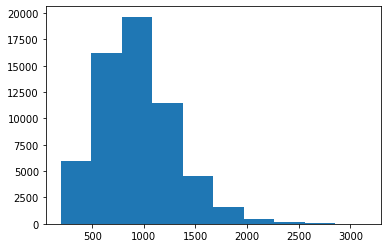

In [ ]:
plt.hist(mnist_x_train_error)

We can see that the distribution of reconstruction errors (anomaly scores) for the training set are approximately normally distributed. We do see there is a small tail, so there may be some anomalous examples in the MNIST training dataset that look different from most other images in the dataset. 

Below, we plot the MNIST training images with the 10 highest reconstruction errors. Note that you may need to rename the variables below depending on what you named your own variables.

[3145.82334929 3003.46686493 2989.06981679 ...  216.27607367  216.25850405
  197.806392  ]


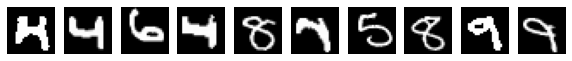

In [ ]:
# Get the indices in sorted order
# use [::-1] reverse the list to get sorting in descending order
# i.e., highest to lowest anomaly scores
sorted_inds = np.argsort(mnist_x_train_error)[::-1]

# Print the sorted errors for reference
print(np.array(mnist_x_train_error)[sorted_inds])
n = 10

fig, axes = plt.subplots(ncols=n, figsize=(10,2))
for i in range(n):
    axes[i].imshow(mnist_x_train[sorted_inds[i]], cmap='gray')
    axes[i].axis('off')

Indeed, some of these do look a bit weird! So we can see why they might have high reconstruction error within the training dataset.

We can also plot the MNIST training images with the 10 *lowest* reconstruction errors to see what strong inlier examples look like.

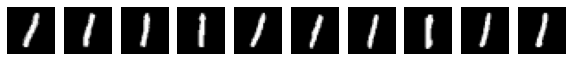

In [ ]:
n = 10

fig, axes = plt.subplots(ncols=n, figsize=(10,2))
for i in range(1, n+1):
    axes[i-1].imshow(mnist_x_train[sorted_inds[-i]], cmap='gray')
    axes[i-1].axis('off')

So far we have just been looking at possible anomalies within the *training* set of MNIST data. Now, we want to use the MNIST and FashionMNIST *test* datasets to compute the anomaly scores for unseen examples (which we know should be inliers and outliers, respectively).

In the cell below, compute the reconstruction errors for the MNIST and FashionMNIST *test* datasets. You will use the same PCA model that you fit to the MNIST training dataset.

In [ ]:
# YOUR CODE HERE
x_test_fash_pca=pca.transform(x_test_fash)
x_test_recon=pca.inverse_transform(X_test_pca)

x_test_fash_recon=pca.inverse_transform(x_test_fash_pca)
mnist_x_test_error=[]
fmnist_x_test_error=[]

for i in range(len(x_test_recon)):
  mnist_x_test_error.append(mse(x_test_recon[i],x_test[i]))

for i in range(len(x_test_fash_recon)):
  fmnist_x_test_error.append(mse(x_test_fash_recon[i],x_test_fash[i]))




Now, plot the histograms of the reconstruction error for each dataset on the same plot. Make sure to include a legend and set the `alpha` parameter so you can see the overlap between the distributions. You can also set `density=True` to normalize the distributions so that the area under each histogram sums to 1.

(array([1.05348791e-04, 1.71550159e-04, 1.29014477e-04, 6.67226385e-05,
        3.24230322e-05, 1.13115723e-05, 3.59676723e-06, 8.86160043e-07,
        3.12762368e-07, 1.04254123e-07]),
 array([  215.09799149,  2133.48735366,  4051.87671583,  5970.266078  ,
         7888.65544017,  9807.04480234, 11725.43416452, 13643.82352669,
        15562.21288886, 17480.60225103, 19398.9916132 ]),
 <a list of 10 Patch objects>)

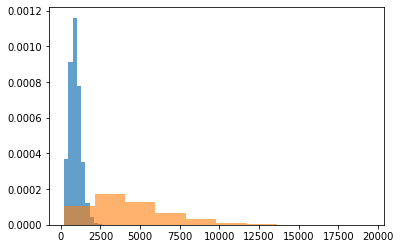

In [ ]:
# YOUR CODE HERE
plt.hist(mnist_x_test_error,density=True,alpha=0.7)
plt.hist(fmnist_x_test_error,density=True,alpha=0.6)

**Question 2: What do these histograms tell us about how well our model is detecting anomalies? Can we say that the model is doing well or poorly?**

**Answer:**

 we can see that the model is performing better for MNSIT data as we can see the propoer normal distribution with a peak and small tail which indicates the anomalies. while the error for the fmist is greater and tail is longer in that case as it was trained on mnist dataset.

In the cell below, visualize the 10 most anomalous examples from the FashionMNIST test set (i.e., the 10 instances with the highest anomaly scores). This will be the first row of the figure.

In addition, you will visualize two more rows for the same images: in the second row, visualize the *reconstructed* version of the image and in the third row, visualize the *squared error* between the input and reconstructed image.

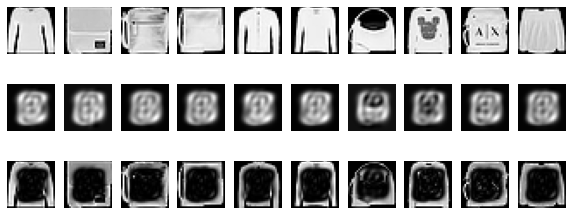

In [ ]:
# YOUR CODE HERE
sorted_inds = np.argsort(fmnist_x_test_error)[::-1]
fig, axes = plt.subplots(ncols=n,nrows=3, figsize=(10,4))
for i in range(n):
    axes[0][i].imshow(fmnist_x_test[sorted_inds[i]], cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(x_test_fash_recon[sorted_inds[i]].reshape(28,28), cmap='gray')
    axes[1][i].axis('off')
    r=[]
    l=fmnist_x_test[sorted_inds[i]].flatten()
    for j in range(len(fmnist_x_test[sorted_inds[i]].flatten())):
      r.append(mse(l[j],x_test_fash_recon[sorted_inds[i]][j]))

    axes[2][i].imshow(np.array(r).reshape(28,28), cmap='gray')
    axes[2][i].axis('off')


In the cell below, create the same 3 rows but using the 10 *least* anomalous exmaples from the FashionMNIST test set (i.e., the 10 instances with the lowest anomaly scores).

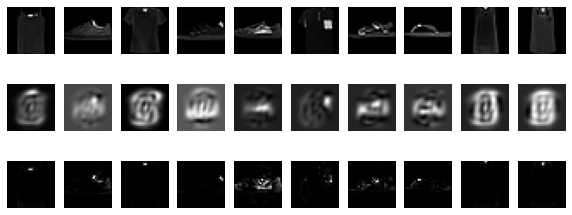

In [ ]:
# YOUR CODE HERE
sorted_inds = np.argsort(fmnist_x_test_error)
fig, axes = plt.subplots(ncols=n,nrows=3, figsize=(10,4))
for i in range(n):
    axes[0][i].imshow(fmnist_x_test[sorted_inds[i]], cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(x_test_fash_recon[sorted_inds[i]].reshape(28,28), cmap='gray')
    axes[1][i].axis('off')
    r=[]
    l=fmnist_x_test[sorted_inds[i]].flatten()
    for j in range(len(fmnist_x_test[sorted_inds[i]].flatten())):
      r.append(mse(l[j],x_test_fash_recon[sorted_inds[i]][j]))

    axes[2][i].imshow(np.array(r).reshape(28,28), cmap='gray')
    axes[2][i].axis('off')


**Question 3: Why do you think images above had the lowest anomaly scores while the images in the previous cell had the highest anomaly scores?**

**Answer:**

The reconostructed images in previous cell are not very clear, hence they have high anomaly score also and the majority of the recon image is obscured. 

In the second part, the recon images can be connected to  the correct images, so low anomaly score.

To compare these reconstructions and difference images for anomalies to those of normal instances, create the same three rows of visualizations for the MNIST test dataset. You can choose whether you want to visualize the least or most anomalous 10 images from the MNIST test dataset.

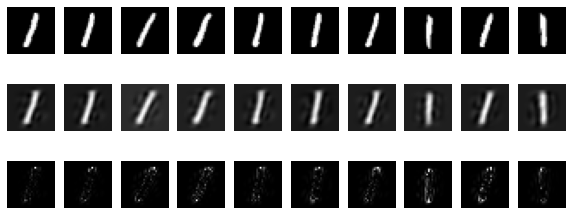

In [ ]:


# YOUR CODE HERE
sorted_inds = np.argsort(mnist_x_test_error)

fig, axes = plt.subplots(ncols=n,nrows=3, figsize=(10,4))
for i in range(n):
    axes[0][i].imshow(mnist_x_test[sorted_inds[i]], cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(x_test_recon[sorted_inds[i]].reshape(28,28), cmap='gray')
    axes[1][i].axis('off')
    r=[]
    l=mnist_x_test[sorted_inds[i]].flatten()
    for j in range(len(mnist_x_test[sorted_inds[i]].flatten())):
      r.append(mse(l[j],x_test_recon[sorted_inds[i]][j]))

    axes[2][i].imshow(np.array(r).reshape(28,28), cmap='gray')
    axes[2][i].axis('off')